### Import Libraries 

In [3]:
import time

# Record the start time
start_time = time.time()

import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline 
import xgboost as xgb

#Need to clean further 

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler,OneHotEncoder, OrdinalEncoder

from sklearn.metrics import confusion_matrix,accuracy_score, classification_report  # Import accuracy_score


from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,StandardScaler, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectPercentile, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn import metrics


from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict

from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, f1_score, precision_score, recall_score, make_scorer

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import UndefinedMetricWarning

# Filter out UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

#Import Custom Functions 
# from Standardization import metric_normalizer
from metrics_functions import custom_classification_metrics as CCM, threshold_viz as TV
import optuna

import warnings


### Import Dataset

In [2]:
df = pd.read_csv('/home/clivence/Development/Datadump/Datadump/Model_Data/GU_Model_Data_V1_16k')

### Data Cleaning

In [3]:
#Filter out negative values - evetually need to research why this is happening 
df  = df[(df['2D Low in Pips'] > 0) | (df['2D Low in Pips'] > 0)] 

df = df[df['Action'] == 'Ultimate Action']
df = df[df['Ticker'] == 'GBP/USD']

df.fillna(0, inplace=True)

#Standardize the dataset
df =  metric_normalizer(df)

#Set date to datetime 
df['Date'] = pd.to_datetime(df['Date'])

#Create Date Derived Features 
df['Trade_Week_Year'] = df['Date'].dt.isocalendar().week
df['Trade_Week_Month'] = (df['Date'].dt.day -1)//7+1
df['Trade_Day_Week'] = df['Date'].dt.weekday + 1

#Create a new feature to identify the status of the previous trade 
df['Previous_Trade_Status'] = df['2D Trade Status'].shift(fill_value=0)


### Data Preprocessing 

In [4]:
#Subset Selection
df = df[['open', 'high', 'low', 'close', 'volume','Trade_Week_Year','Trade_Week_Month','Trade_Day_Week',
       'Day','Month','25EMA', '50EMA', '75EMA','100EMA', '125EMA',
        'Trend Status', 'Spread','5075 Trend Status', '75100 Trend Status',
       '100125 Trend Status', 'Order Type', 
        '%K', '%D', 'k_group', 'ADX', 'ADXR', 'slowk','slowd','CDL2CROWS', 'CDL3BLACKCROWS',
        'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE',
        'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK',
        'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL',
        'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJISTAR', 'CDLDRAGONFLYDOJI',
        'CDLENGULFING', 'CDLEVENINGDOJISTAR', 'CDLEVENINGSTAR', 'CDLGAPSIDESIDEWHITE',
        'CDLGRAVESTONEDOJI', 'CDLHAMMER', 'CDLHANGINGMAN', 'CDLHARAMI', 'CDLHARAMICROSS',
        'CDLHIGHWAVE', 'CDLHIKKAKE', 'CDLHIKKAKEMOD', 'CDLHOMINGPIGEON', 'CDLIDENTICAL3CROWS',
        'CDLINNECK', 'CDLINVERTEDHAMMER', 'CDLKICKING', 'CDLKICKINGBYLENGTH', 'CDLLADDERBOTTOM',
        'CDLLONGLEGGEDDOJI', 'CDLLONGLINE', 'CDLMARUBOZU', 'CDLMATCHINGLOW', 'CDLMATHOLD',
        'CDLMORNINGDOJISTAR', 'CDLMORNINGSTAR', 'CDLONNECK', 'CDLPIERCING', 'CDLRICKSHAWMAN',
        'CDLRISEFALL3METHODS', 'CDLSEPARATINGLINES', 'CDLSHOOTINGSTAR', 'CDLSHORTLINE',
        'CDLSPINNINGTOP', 'CDLSTALLEDPATTERN', 'CDLSTICKSANDWICH', 'CDLTAKURI', 'CDLTASUKIGAP',
        'CDLTHRUSTING', 'CDLTRISTAR', 'CDLUNIQUE3RIVER', 'CDLUPSIDEGAP2CROWS', 'CDLXSIDEGAP3METHODS',
        'candle_bullish_score','candle_bearish_score','Previous_Trade_Status','2D Trade Status']]

#Set a random state 
state =42

In [5]:
# Set training, test, and validation set size 
total_len = len(df)
training_size = int(total_len * .8)
validation_size = int(total_len * .1)
test_size = total_len - training_size - validation_size

# Split indices
training_idx = df.index[:training_size]
validation_idx = df.index[training_size:training_size + validation_size]
test_idx = df.index[training_size + validation_size:]

# Verify lengths
assert len(training_idx) == training_size
assert len(test_idx) == test_size
assert len(validation_idx) == validation_size

# Create training, test, and validation df 
training_df = df.loc[training_idx]
validation_df = df.loc[validation_idx]
test_df = df.loc[test_idx]

# Print lengths of the three DataFrames
print(f"Training: {len(training_df)}")
print(f"Validation: {len(validation_df)}")
print(f"Test: {len(test_df)}")

Training: 386
Validation: 48
Test: 49


In [6]:
X_train = training_df.drop(columns=['2D Trade Status'])
y_train = training_df['2D Trade Status']
X_val = validation_df.drop(columns=['2D Trade Status'])
y_val = validation_df['2D Trade Status']
X_test = test_df.drop(columns=['2D Trade Status'])
y_test = test_df['2D Trade Status']

In [7]:
#Create a list of columns to encode 
cat_cols_to_encode = ['Order Type']
#Create a list of cols for ordinal encoding 
cat_cols_for_ordinal_encoding = ['Trend Status','5075 Trend Status', '75100 Trend Status',
                    '100125 Trend Status','k_group']

#Create a list of cols to scale 
num_cols_to_scale = ['volume']

# Create Column Transformer with appropriate preprocessing for numerical and categorical data
Preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
            ('scaler', MinMaxScaler())]), num_cols_to_scale),
        ('cat_onehot', OneHotEncoder(drop='first', sparse_output=False), cat_cols_to_encode),
        ('cat_ordinal', OrdinalEncoder(), cat_cols_for_ordinal_encoding)
    ],
    remainder='passthrough')

# Preprocessor.set_output(transform='pandas')

## Base Models

### Logistic Regression

/home/clivence/.pyenv/versions/3.12.3/envs/DEV/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Validation Accuracy: 0.646
Validation Precision: 0.705

Classification Report:
               precision    recall  f1-score   support

 Loss Trades       0.00      0.00      0.00        13
  Win Trades       0.70      0.89      0.78        35

    accuracy                           0.65        48
   macro avg       0.35      0.44      0.39        48
weighted avg       0.51      0.65      0.57        48



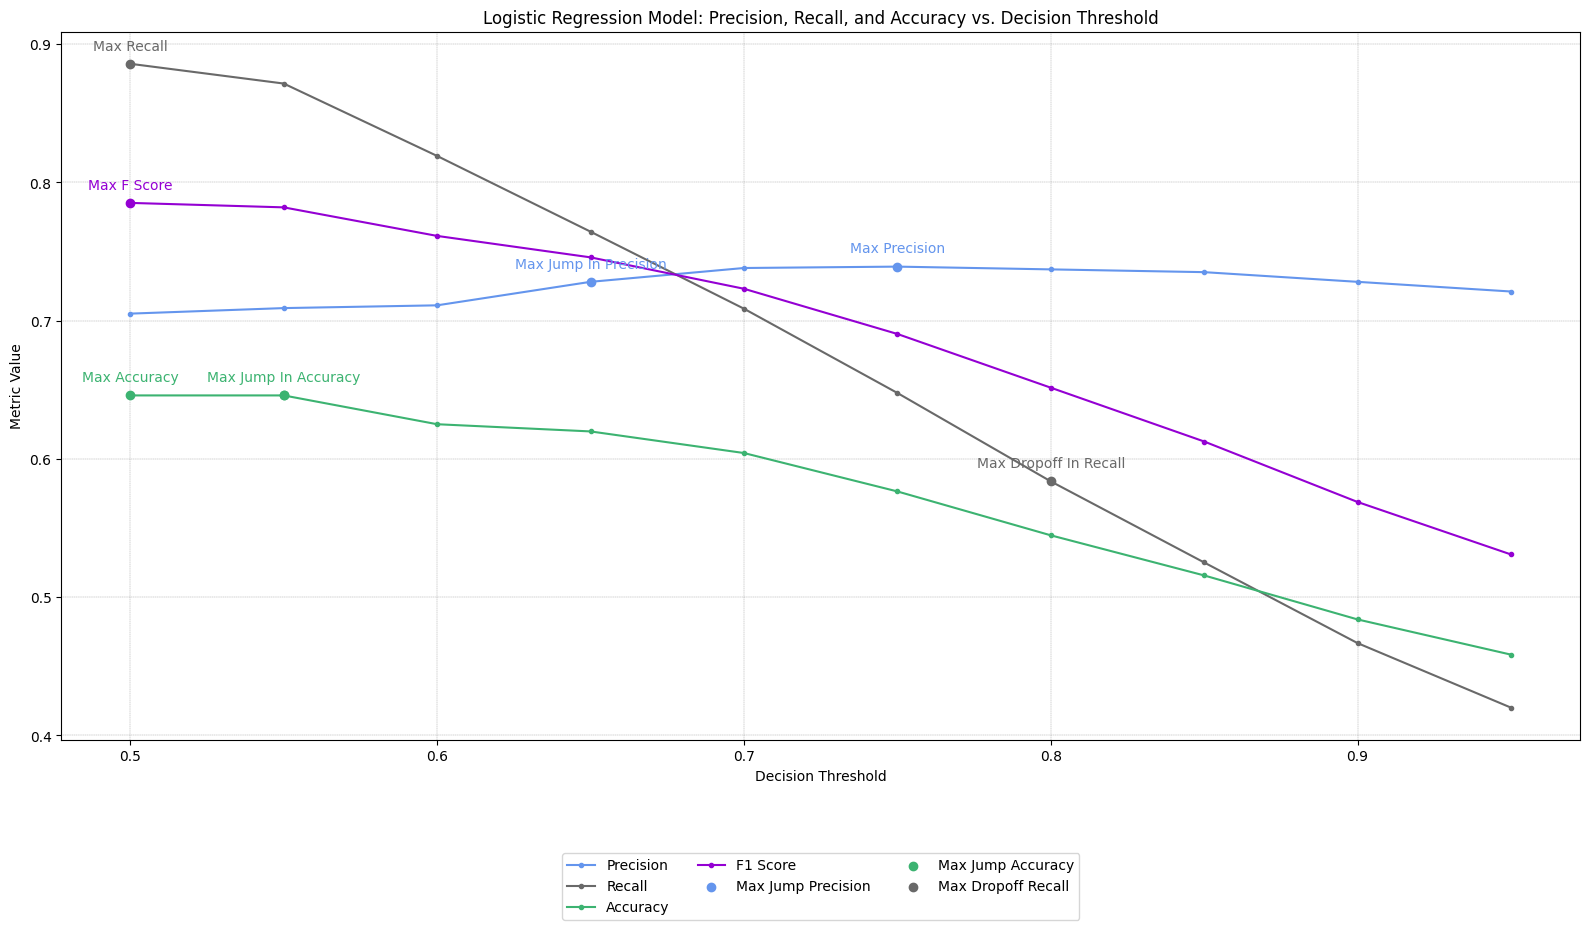

In [19]:
#Create PiPeline to be used in Model
Base_LR_Model_Pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor),
    ('LR_Model',LogisticRegression())])

# Perform cross-validation
Base_LR_Model_Pipeline.fit(X_train, y_train)
Base_LR_Model_Predictions = Base_LR_Model_Pipeline.predict(X_val)

# Calculate the accuracy & precision of the model
accuracy = accuracy_score(y_val, Base_LR_Model_Predictions)
precision = precision_score(y_val, Base_LR_Model_Predictions)
print(f"\nValidation Accuracy: {round(accuracy,3)}\n\
Validation Precision: {round(precision,3)}\n")


# Generate and Print  classification report
report = classification_report(y_val, Base_LR_Model_Predictions, target_names=["Loss Trades", "Win Trades"]) 
print("Classification Report:\n", report)

#Get Predictions Probability 
predictions_array = Base_LR_Model_Pipeline.predict_proba(X_val)[:, 1]

#Get y_values
true_arrray= y_val

#Create custom classification metrics 
metrics= CCM(true_arrray, predictions_array)

##Visualized  Metrics 
model_name= 'Logistic Regression Model'
viz = TV(metrics,model_name)

### XGBoost Classifier


Validation Accuracy: 0.6875


Validation Accuracy: 0.688
Validation Precision: 0.727



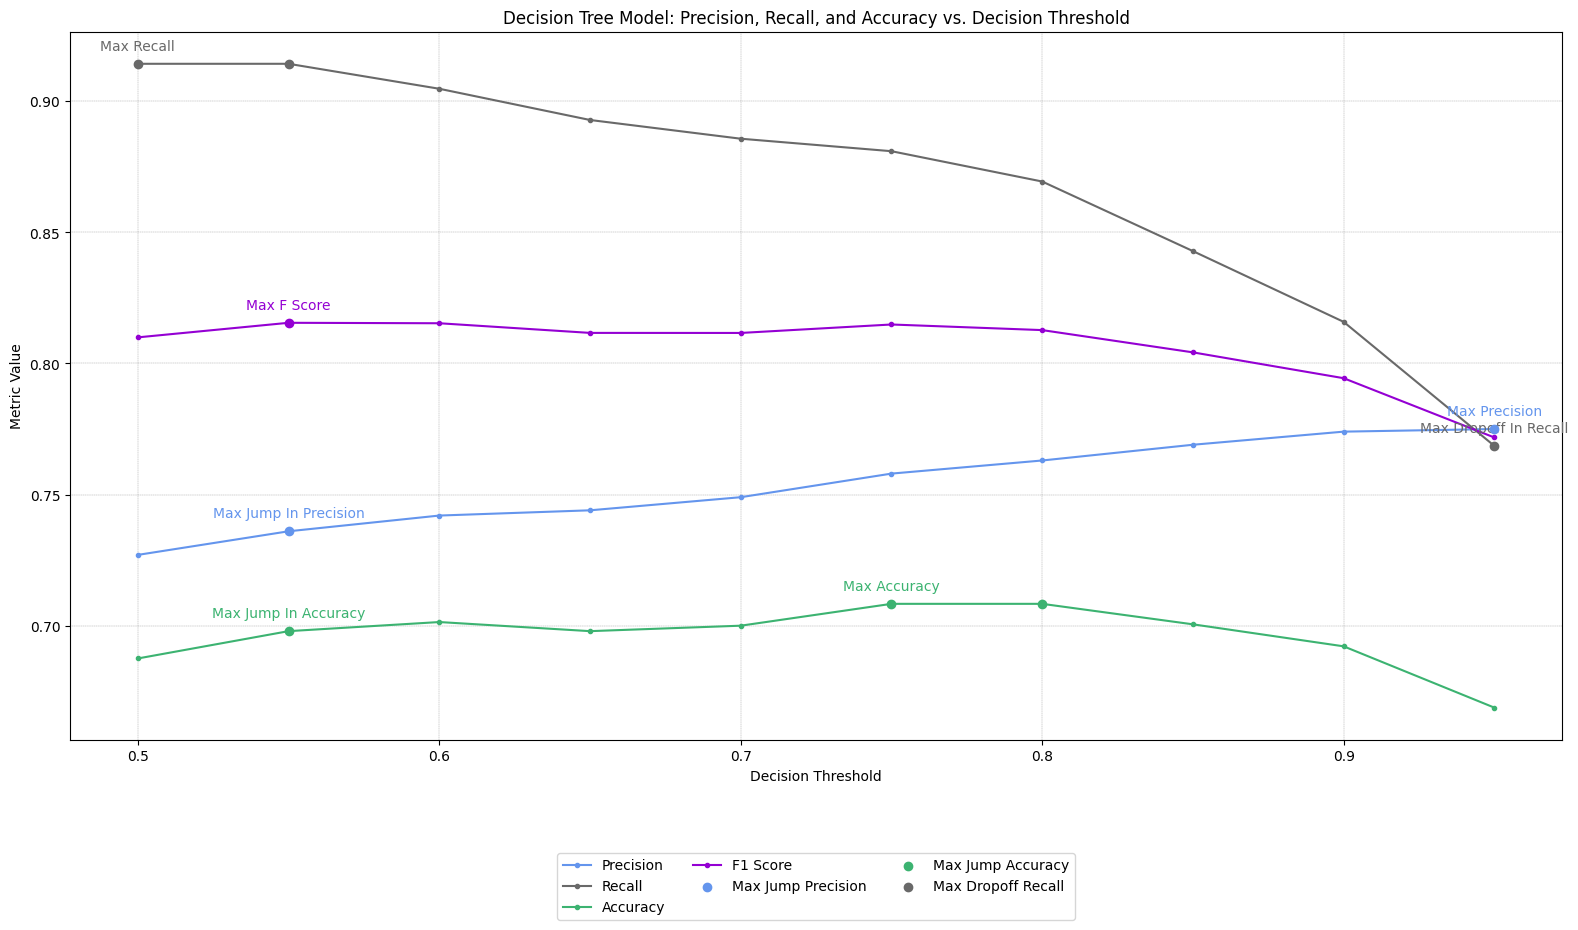

In [26]:
#Create Pipeline to be used in Gradient Boosting Classfier Model
Base_XGB_Model_Pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor),
    ('XGB_Model',xgb.XGBClassifier(random_state=state))])

#Fit the training data 
Base_XGB_Model_Pipeline.fit(X_train, y_train)

# Perform cross-validation
XGB_predictions = Base_XGB_Model_Pipeline.predict(X_val)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_val, XGB_predictions)
print(f"\nValidation Accuracy: {accuracy}\n")

# Calculate the accuracy & precision of the model
accuracy = accuracy_score(y_val, XGB_predictions)
precision = precision_score(y_val, XGB_predictions)
print(f"\nValidation Accuracy: {round(accuracy,3)}\n\
Validation Precision: {round(precision,3)}\n")


#Get Predictions Probability 
predictions_array = Base_XGB_Model_Pipeline.predict_proba(X_val)[:, 1]

#Get y_values
true_arrray= y_val

#Create custom classification metrics 
metrics= CCM(true_arrray, predictions_array)

##Visualized  Metrics 
model_name= 'Decision Tree Model'
viz = TV(metrics,model_name)

# Grid Search & Cross Validate Top Models 

## Logistic Regression

### Accuracy

In [27]:
# Define parameter grid for logistic regression
Log_reg_param_grid = {
    # Regularization strength
    'LR_Model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    # Penalty norm
    'LR_Model__penalty': ['l1', 'l2'],
    # Solvers that support 'l1' penalty
    'LR_Model__solver': ['liblinear', 'saga'],
     # Maximum iterations
    'LR_Model__max_iter': [100, 200, 300, 400, 500, 1000] 
}

# Define and run GridSearchCV
grid_search_lr = GridSearchCV(Base_LR_Model_Pipeline, param_grid=Log_reg_param_grid, cv=3, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)

# Get best parameters and score
best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

# Train the model with the best parameters on the entire validation dataset
best_log_reg_model = grid_search_lr.best_estimator_
best_log_reg_model.fit(X_val, y_val)

/home/clivence/.pyenv/versions/3.12.3/envs/DEV/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/clivence/.pyenv/versions/3.12.3/envs/DEV/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/clivence/.pyenv/versions/3.12.3/envs/DEV/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/clivence/.pyenv/versions/3.12.3/envs/DEV/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/clivence/.pyenv/versions/3.12.3/envs/DEV/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['volume']),
                                                 ('cat_onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Order Type']),
                                                 ('cat_ordinal',
                                                  OrdinalEncoder(),
                                                  ['Trend Status',
                                                   '5075 Trend Status',
                                                   '75100 Trend Status',
                                                   '100125 Trend Status',
                                                   'k_group'])])),
                ('LR_Model',
                 LogisticRegression(C=0.001, penalty='l1',
                                    solver='liblinear'))])

In [32]:
print(f"Best Parameters for Logistic Regression: \n {best_params_lr}")
print(f"Best Accuracy Score for Logistic Regression: {best_score_lr}")

# Predict the labels for the validation data
y_val_pred = best_log_reg_model.predict_proba(X_val)[:, 1]

# Make predictions on the validation set
Base_LR_Model_Predictions = best_log_reg_model.predict(X_val)

# Calculate the accuracy & precision of the model
accuracy = accuracy_score(y_val, Base_LR_Model_Predictions)
precision = precision_score(y_val, Base_LR_Model_Predictions)

print(f"\nValidation Accuracy: {round(accuracy, 3)}\nValidation Precision: {round(precision, 3)}\n")

Best Parameters for Logistic Regression: 
 {'LR_Model__C': 0.001, 'LR_Model__max_iter': 100, 'LR_Model__penalty': 'l1', 'LR_Model__solver': 'liblinear'}
Best Accuracy Score for Logistic Regression: 0.6813428617571059

Validation Accuracy: 0.604
Validation Precision: 0.808



## Random Forest

In [39]:
# Define parameter grid for RandomForestClassifier
param_grid = {
    'RF_Model__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'RF_Model__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'RF_Model__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'RF_Model__min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'RF_Model__max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
}

# Grid search with precision scoring
grid_search_precision = GridSearchCV(Base_RF_Model_Pipeline, param_grid=param_grid, cv=3, scoring='precision')
grid_search_precision.fit(X_train, y_train)
best_params_precision = grid_search_precision.best_params_
best_score_precision = grid_search_precision.best_score_

print(f"Best Parameters with Precision: {best_params_precision}")
print(f"Best Precision Score: {best_score_precision}")


Best Parameters: {'RF_Model__max_depth': 10, 'RF_Model__max_features': 'log2', 'RF_Model__min_samples_leaf': 1, 'RF_Model__min_samples_split': 2, 'RF_Model__n_estimators': 200}
Best Score: 0.6675044570964705


In [43]:
# Extract the best model tune for precision 
best_rf_precision_model = grid_search_precision.best_estimator_
#Make predictions o the validation data
Tuned_For_Precision_RF_Preds = best_rf_precision_model.predict(X_val)

# Calculate the accuracy & precision of the model
accuracy = accuracy_score(y_val, Tuned_For_Precision_RF_Preds)
precision = precision_score(y_val, Tuned_For_Precision_RF_Preds)

print(f"Tune for Precision:\n \nValidation Accuracy: {round(accuracy, 3)}\nValidation Precision: {round(precision, 3)}\n")



Tune for Precision:
 
Validation Accuracy: 0.729
Validation Precision: 0.729



## Gradient Boosting 

In [44]:
from sklearn.model_selection import GridSearchCV, KFold

# Define the parameters grid for GridSearchCV
param_grid = {
    'GBC_Model__learning_rate': [0.05, 0.1, 0.2],
    'GBC_Model__n_estimators': [50, 100, 200, 300],
    'GBC_Model__max_depth': [3, 5, 7],
    'GBC_Model__min_samples_split': [2, 5, 10],
    'GBC_Model__min_samples_leaf': [1, 2, 4],
    'GBC_Model__subsample': [0.8, 0.9, 1.0],
    'GBC_Model__max_features': ['sqrt', 'log2', None]
}

# Define the GridSearchCV with 2-fold cross-validation
grid_search = GridSearchCV(estimator=Base_GBC_Model_Pipeline, 
                           param_grid=param_grid, 
                           cv=3,
                           scoring='precision',
                           verbose=1,
                           n_jobs=-1  # Use all available processors
                          )

# Fit the grid search to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best model found by GridSearchCV
best_model = grid_search.best_estimator_

# Predict with the best model on the validation set
GBC_predictions = best_model.predict(X_val)

# Calculate accuracy and precision with the best model
accuracy = accuracy_score(y_val, GBC_predictions)
precision = precision_score(y_val, GBC_predictions)

# Print results
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"\nValidation Accuracy: {round(accuracy, 3)}")
print(f"Validation Precision: {round(precision, 3)}")


Fitting 3 folds for each of 9 candidates, totalling 27 fits

Best Parameters: {'GBC_Model__learning_rate': 0.05, 'GBC_Model__n_estimators': 50}

Validation Accuracy: 0.708
Validation Precision: 0.723


## XGBoost

In [45]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'XGB_Model__n_estimators': [100, 200, 300, 400],
    'XGB_Model__max_depth': [3, 5, 7, 9],
    'XGB_Model__learning_rate': [0.05, 0.1, 0.2],
    'XGB_Model__subsample': [0.8, 1.0],
    'XGB_Model__colsample_bytree': [0.8, 1.0],
    'XGB_Model__gamma': [0, 0.1, 0.2],
    'XGB_Model__reg_alpha': [0, 0.1, 0.5],
    'XGB_Model__reg_lambda': [0, 0.1, 0.5],
    'XGB_Model__min_child_weight': [1, 3, 5]
}

# Create a GridSearchCV object with 2-fold cross-validation
grid_search = GridSearchCV(estimator=Base_XGB_Model_Pipeline, param_grid=param_grid, 
                           cv=3,
                           scoring='precision', verbose=1, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding validation accuracy
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
XGB_predictions = best_model.predict(X_val)
accuracy = accuracy_score(y_val, XGB_predictions)
precision = precision_score(y_val, XGB_predictions)
print(f"\nValidation Accuracy: {round(accuracy, 3)}")
print(f"Validation Precision: {round(precision, 3)}")


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters: {'XGB_Model__max_depth': 3, 'XGB_Model__n_estimators': 100}
Best cross-validation accuracy: 0.7268868561166338

Validation Accuracy: 0.646
Validation Precision: 0.705


# Optuna

## Logistic Regression

[I 2024-07-10 11:57:49,561] A new study created in memory with name: no-name-141b69a2-c847-46db-a92e-315dab84ad65
/home/clivence/.pyenv/versions/3.12.3/envs/DEV/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/clivence/.pyenv/versions/3.12.3/envs/DEV/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/clivence/.pyenv/versions/3.12.3/envs/DEV/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-07-10 11:57:50,903] Trial 0 finished with value: 0.6450662144702842 and parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 700}. Best is trial 0 with value: 0.6450662144702842.
[I 2024-07-10 11:57:51,172] Trial 1 finished with v

Best Parameters for Logistic Regression:
{'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 700}
Best Precision Score for Logistic Regression: 0.6813428617571059
Validation Precision Score for Logistic Regression: 0.7291666666666666


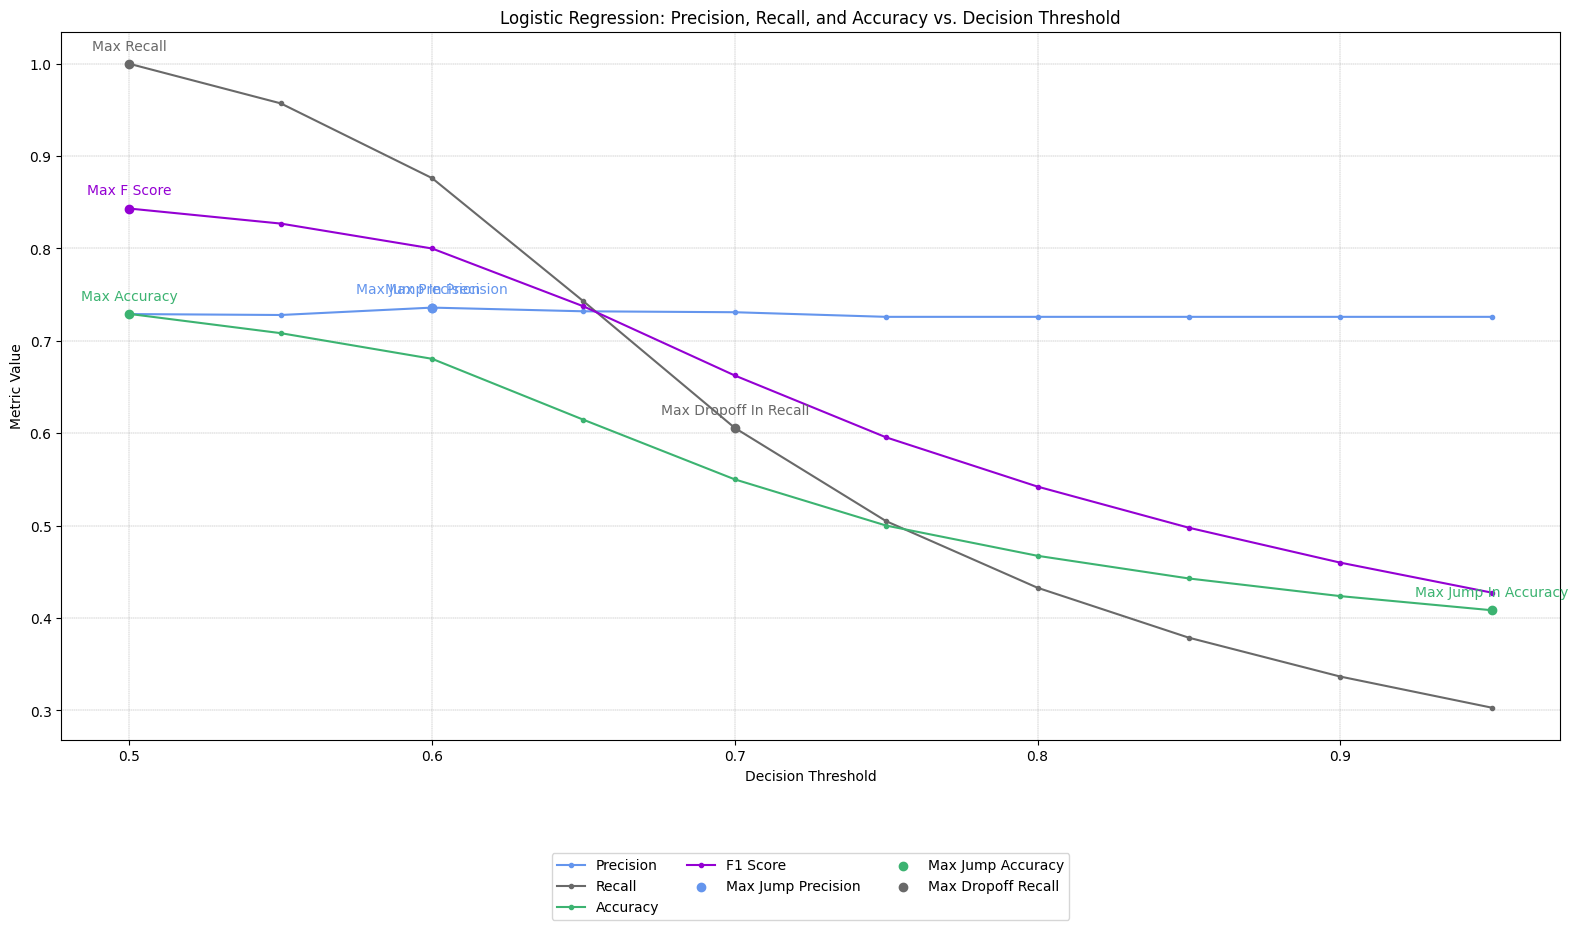

In [75]:
# Define your preprocessor
Preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', MinMaxScaler())
        ]), ['volume']),
        ('cat_onehot', OneHotEncoder(drop='first'), ['Order Type']),  # Removed sparse_output=False
        ('cat_ordinal', OrdinalEncoder(), ['Trend Status', '5075 Trend Status', 
                                           '75100 Trend Status', '100125 Trend Status', 'k_group'])
    ],
    remainder='passthrough'
)

# Define the objective function
def objective(trial):
    C = trial.suggest_categorical('C', [0.001, 0.01, 0.1, 1, 10, 100, 1000])
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 1000, step=100)
    
    model_pipeline = Pipeline(steps=[
        ('Preprocessor', Preprocessor),
        ('LR_Model', LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            max_iter=max_iter,
            random_state=0
        ))
    ])
    
    # Use cross-validation to evaluate precision
    precision = cross_val_score(model_pipeline, X_train, y_train, cv=3, scoring='accuracy').mean()
    
    return precision

# Create Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get best parameters and score
best_params_lr = study.best_params
best_precision_lr = study.best_value

# Train the best model on the entire training dataset with best parameters
best_log_reg_model = Pipeline(steps=[
    ('Preprocessor', Preprocessor),
    ('LR_Model', LogisticRegression(
        C=best_params_lr['C'],
        penalty=best_params_lr['penalty'],
        solver=best_params_lr['solver'],
        max_iter=best_params_lr['max_iter'],
        random_state=0
    ))
])

best_log_reg_model.fit(X_train, y_train)

print(f"Best Parameters for Logistic Regression:\n{best_params_lr}")
print(f"Best Precision Score for Logistic Regression: {best_precision_lr}")

# Predict the labels for the validation data
y_val_pred = best_log_reg_model.predict_proba(X_val)[:, 1]

# Evaluate the model on the validation data
test_precision_lr = precision_score(y_val, (y_val_pred > 0.5).astype(int))
print(f"Validation Precision Score for Logistic Regression: {test_precision_lr}")

# Get y_values
true_array = y_val

# Create custom classification metrics
metrics = CCM(true_array, y_val_pred)

# Visualize Metrics
model_name = 'Logistic Regression'
viz = TV(metrics, model_name)

## Random Forest

In [ ]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 50)  # Increased max_depth range
    n_estimators = trial.suggest_int('n_estimators', 100, 2000)  # Increased n_estimators range
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)  # Increased min_samples_split range
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)  # Increased min_samples_leaf range
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 0.5, 0.7])  # Added numeric options for max_features

    
    model_pipeline = Pipeline(steps=[
        ('Preprocessor', Preprocessor),  # Assuming Preprocessor is defined elsewhere
        ('RF_Model', RandomForestClassifier(
            random_state=state,
            max_depth=max_depth,
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features
        ))
    ])
    
    model_pipeline.fit(X_train, y_train)
    predictions = model_pipeline.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best hyperparameters: ", best_params)

final_model_pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor),
    ('RF_Model', RandomForestClassifier(
        random_state=state,
        **best_params
    ))
])

final_model_pipeline.fit(X_train, y_train)

test_predictions = final_model_pipeline.predict(X_val)
test_accuracy = accuracy_score(y_val, test_predictions)
print(f"\nTest Accuracy: {test_accuracy}\n")
test_report = classification_report(y_val, test_predictions, target_names=["Loss Trades", "Win Trades"])
print("Test Classification Report:\n", test_report)


## Gradient Boosting 

In [44]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    model_pipeline = Pipeline(steps=[
        ('Preprocessor', Preprocessor),
        ('GBC_Model', GradientBoostingClassifier(
            random_state=state,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            subsample=subsample,
            max_features=max_features
        ))
    ])
    
    model_pipeline.fit(X_train, y_train)
    predictions = model_pipeline.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best hyperparameters: ", best_params)

final_model_pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor),
    ('GBC_Model', GradientBoostingClassifier(
        random_state=state,
        **best_params
    ))
])

final_model_pipeline.fit(X_train, y_train)

test_predictions = final_model_pipeline.predict(X_val)
test_accuracy = accuracy_score(y_val, test_predictions)
print(f"\nTest Accuracy: {test_accuracy}\n")
test_report = classification_report(y_val, test_predictions, target_names=["Loss Trades", "Win Trades"])
print("Test Classification Report:\n", test_report)

[I 2024-07-09 02:23:48,509] A new study created in memory with name: no-name-3e111b0d-4643-4c35-8188-52f55894c347
[I 2024-07-09 02:23:48,979] Trial 0 finished with value: 0.7291666666666666 and parameters: {'learning_rate': 0.08988017267869684, 'n_estimators': 192, 'max_depth': 14, 'min_samples_split': 43, 'min_samples_leaf': 48, 'subsample': 0.5223366252200283, 'max_features': 'log2'}. Best is trial 0 with value: 0.7291666666666666.
[I 2024-07-09 02:23:49,442] Trial 1 finished with value: 0.6458333333333334 and parameters: {'learning_rate': 0.20599651400696625, 'n_estimators': 203, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 26, 'subsample': 0.3301743680791057, 'max_features': None}. Best is trial 0 with value: 0.7291666666666666.
[I 2024-07-09 02:23:49,876] Trial 2 finished with value: 0.6041666666666666 and parameters: {'learning_rate': 0.28988968938642007, 'n_estimators': 115, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 5, 'subsample': 0.445985576

Best hyperparameters:  {'learning_rate': 0.03688656320209233, 'n_estimators': 911, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 34, 'subsample': 0.5528607274645768, 'max_features': 'log2'}

Test Accuracy: 0.8163265306122449

Test Classification Report:
               precision    recall  f1-score   support

 Loss Trades       0.00      0.00      0.00         8
  Win Trades       0.83      0.98      0.90        41

    accuracy                           0.82        49
   macro avg       0.42      0.49      0.45        49
weighted avg       0.70      0.82      0.75        49



In [45]:
#Get Predictions Probability 
predictions_array = final_model_pipeline.predict_proba(X_test)[:, 1]

#Get y_values
true_arrray= y_test

#Create custom classification metrics 
metrics= CCM(true_arrray, predictions_array)

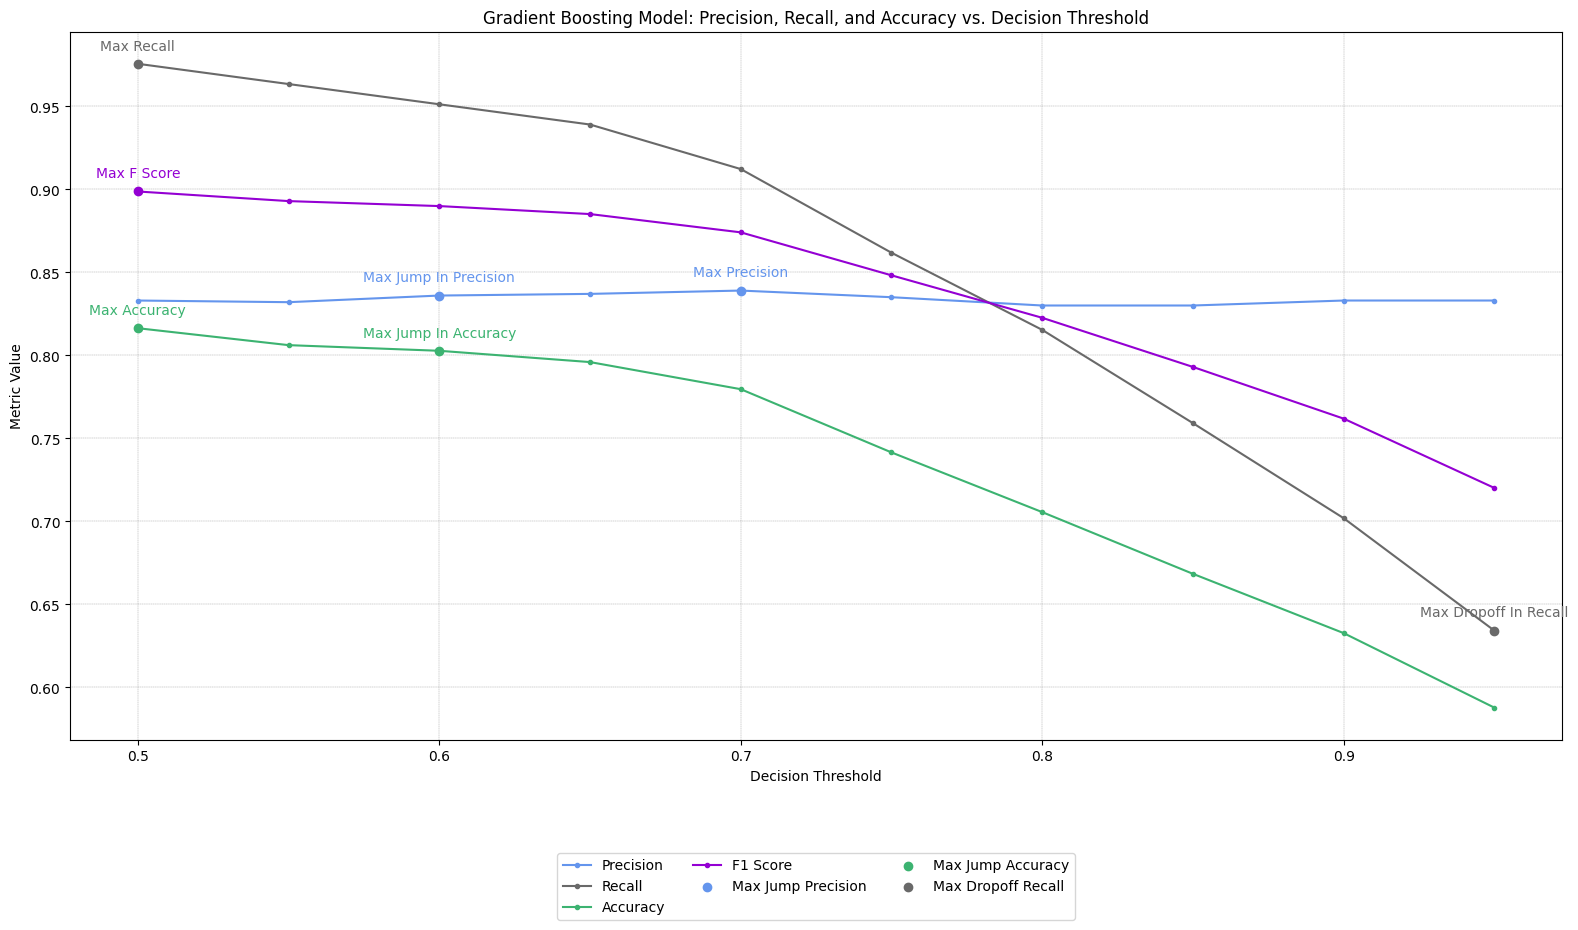

In [46]:
##Visualized  Metrics 
model_name= 'Gradient Boosting Model'
viz = TV(metrics,model_name)

## XGboost 

In [ ]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import optuna

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.1, 10.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 100.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 100.0),
        'scale_pos_weight': trial.suggest_loguniform('scale_pos_weight', 1e-6, 100.0),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
        'tree_method': 'hist'  # Use 'hist' for faster training
    }
    
    model_pipeline = Pipeline(steps=[
        ('Preprocessor', Preprocessor),  # Assuming Preprocessor is defined elsewhere
        ('XGB_Model', xgb.XGBClassifier(
            **params,
            random_state=state,
            objective='binary:logistic'  # Adjust objective as needed
        ))
    ])
    
    model_pipeline.fit(X_train, y_train)
    predictions = model_pipeline.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best hyperparameters: ", best_params)

final_model_pipeline = Pipeline(steps=[
    ('Preprocessor', Preprocessor),
    ('XGB_Model', xgb.XGBClassifier(
        **best_params,
        random_state=state,
        objective='binary:logistic'  # Adjust objective as needed
    ))
])

final_model_pipeline.fit(X_train, y_train)

test_predictions = final_model_pipeline.predict(X_val)
test_accuracy = accuracy_score(y_val, test_predictions)
print(f"\nTest Accuracy: {test_accuracy}\n")
test_report = classification_report(y_val, test_predictions, target_names=["Loss Trades", "Win Trades"])
print("Test Classification Report:\n", test_report)


In [ ]:
# Record the end time
end_time = time.time()

# Calculate the duration in seconds
duration_seconds = end_time - start_time

# Convert duration to hours
duration_hours = duration_seconds / 3600  # There are 3600 seconds in an hour

print(f"Execution time: {duration_hours:.2f} hours")

## Reference: Concepts To Understand 

#### Accuracy: 
                - Measures the overall correctness of the classifier. It's calculated by dividing the number of correctly classifier samples by the total number of samples. 
                - Accuracy tells us how often the classifier correctly predicted whether a trade is a successful or not compared to the total number of trades.
                - An Accuracy of .76 means that classifier correctly predicted the trade status for approximately 76% of the time. 
                
#### Recall:
             - Also known as sensitivity or true positive, measures  the ability of the classifier to correctly identify all positive instances. 
             - In the context of a trade status classifier, recall tells us how often the classifier correctly identified out of all successful trades.
             - A recall of approximately .795 means that the classifier correctly identified 79.5% of the successful trades. 
#### Precision 
              - Measures the ability of the classifier to correctly identify only relevant instances among all instances it has classified as positive. 
              - In the context of a trade status classifier, precision measures the proportion of correctly predicted successful trades out of all successful trades.
              - A precision of approximately .933 means that about 93.3% of the trades predicted as successful by the classifier were actually successful. 
#### F1 Score
                - Is a metric that combines precision and recall into a single value - it is the harmonic mean between precision and recall. 
                - Precision measures the proportion of correctly predicted positive cases among all predicted cases.
                - While Recall, measures the proportion of correctly predicted positive cases among all actual positive cases.
                - F1 Score provides a balance between precision and recall, it is especially useful when there is an uneven class distribution.
                - In the context of a trade status classifier, an F1 Score of .859 indicate a good balance between precision and recall predicting whether trades were successful or not. 


### Example Summary and Key Takeaways

#### Performance Overview
- **Test Accuracy**: 75%.

#### Insights from Classification Report
- **'Win Trades' (Positive Class)**:
  - Precision: ~76%
  - Recall: ~97%
  - F1-score: ~0.85
- **'Loss Trades' (Negative Class)**:
  - Precision: ~67%
  - Recall: ~15%
  - F1-score: ~0.25

#### Key Takeaways
1. **Strong Performance on Majority Class**:
   - The model is highly effective in predicting 'Win Trades', with high precision and recall. This indicates strong performance for the majority class.
2. **Challenges with Minority Class**:
   - Despite a reasonable precision, the recall for 'Loss Trades' is very low, suggesting that the model struggles to identify this class correctly. The low recall for 'Loss Trades' needs addressing to balance the model's performance across classes.
3. **Potential for Model Tuning**:
   - Improving the model's ability to detect 'Loss Trades' could involve tuning hyperparameters, exploring different model architectures, or employing techniques aimed at balancing class representation.
4. **Metrics Indicating Room for Improvement**:
   - While the overall accuracy is good, the macro averages for precision, recall, and F1-score suggest that the performance across classes is uneven, reinforcing the need for model refinement to ensure fairness and robustness.

This summary pinpoints where the model excels and where improvements are necessary, especially in handling the minority class more effectively.
